In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/TCGA/')

In [3]:
#importing libraries
import numpy as np
import sys

import tensorflow as tf
import os
import sys
import pandas as pd
%matplotlib inline  
import matplotlib.image as img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2          
import seaborn as sns
from sklearn.metrics import f1_score   
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torchvision
import torch.optim as optim
import glob
from skimage import exposure
import gc
from sklearn.metrics import roc_auc_score
from scipy import sparse


from PIL import Image
import random 
import time
import copy

In [4]:
# check if the device on the GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('The used device is:', device)

The used device is: cuda:0


# Data Pre-processing

In [5]:
########### Class to create a custom dataloader of the dataset ##########
class TCGADataset(Dataset):
    def __init__(self, transform = None):
        self.imgs_path = "/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/"
        self.transform = transform
        img_list = glob.glob(self.imgs_path + "*")
       
        self.data = []
        self.labels_list = []
        for class_path in img_list:
            class_name = class_path.split("/")[-1] 
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
                self.labels_list.append(class_name)
        print("Data list are", self.data)
        print("Labels list are", self.labels_list)
        print(len(self.data))
        self.class_map = {"WT" : 0, "Mutant": 1}
       
      
    def __len__(self):
        return len(self.data)
    
    def __gelabels__(self):
      lables = []
      for i in self.labels_list:
        if i == 'WT':
          i = 0
        else:
          i = 1
        lables.append(i)
      print("The length of the target labels", len(lables))
      return lables

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        image = cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        class_id = self.class_map[class_name]
        return image , class_id

In [16]:
'''
Resize the shorter side of the image to 256 while maintaining the aspect ratio
Do a random crop of size ranging from 50% to 100% of the dimensions of the
image, and aspect ratio ranging randomly from 75% to 133% of the original 
aspect ratio. Finally, the crop is resized to 224 × 224
Horizontally flip the image with a probability of 0.5
Normalize the image to have 0 mean and standard deviation of 1

For testing set:
Resize the image to 224 × 224.
Normalize the image to have mean 0 and standard deviation of 1
'''
transformer = transforms.Compose([                                      
    transforms.ToPILImage(),
    transforms.Resize((224,224)),  
   # transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])


#get the dataset along with their transformers
dataset = TCGADataset(transform = transformer)

Data list are [['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4935-1.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4935-2.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4935-3.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/ TCGA-76-4932-2.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/ TCGA-76-4932-3.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/ TCGA-76-4932-1.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4934-1.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4934-2.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4934-3.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4931-1.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/dataset/WT/TCGA-76-4931-2.jpg', 'WT'], ['/content/drive/MyDrive/Colab Notebooks/TCGA/d

In [17]:
# get the labels ids of the whole dataset in a list
labels_ids = dataset.__gelabels__()

# get a stratied samples of the training and testing sets 
train_indices, test_indices= train_test_split(
np.arange(len(labels_ids)),
test_size=0.2,
shuffle = True,
stratify=labels_ids)

print("The length of the training set is", len(train_indices))
print("The length of the testing set is", len(test_indices))

The length of the target labels 189
The length of the training set is 151
The length of the testing set is 38


In [18]:
########### Create data samplers and loaders ############
batch_size = 32

train_sampler = SubsetRandomSampler(train_indices)

test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)

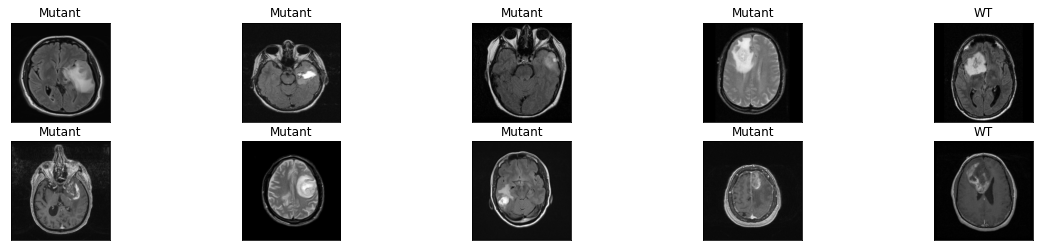

In [23]:
############ Display a sample of the TCGA images ################
target_classes = ['Mutant','WT']

# helper function to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from a Tensor image

# obtain one batch of the training data
dataiter = iter(train_loader)
img, labels = dataiter.next()
img = img.numpy() # convert images to numpy for display

# plot the images with the corresponding labels
fig = plt.figure(figsize=(20, 4))

# display 10 random images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow((img[idx]))
    ax.set_title(target_classes[labels[idx]])

# Modelling

**Train and Test without freezing**

In [24]:
# define ResNet50 model with ImageNet weights 
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(target_classes)) # target_classes = 2 

# move the model to GPU if CUDA is available
model.to(device)

#set the type of the loss function
criterion = nn.CrossEntropyLoss()  

# define the hyperparameters of the optimization algorithm
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
# show the layers architecture of the ResNet model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
######## The training model function #########
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    start_time = time.time() #(for showing time)
    for epoch in range(num_epochs): #(loop for every epoch)
        print("Epoch {} running".format(epoch)) #(printing message)
        
        model.train()    #(training model)
        running_loss = 0.   #(set loss 0)
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)

            # get the predictions
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_sampler)
        epoch_acc = running_corrects / len(train_sampler) * 100.

        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    #save the trained model
    saved_trained_model = 'classifier_resnet_50.pth'
    torch.save(model.state_dict(), saved_trained_model)
    trained_model = model.load_state_dict(torch.load(saved_trained_model))

    return trained_model

In [32]:
##Testing
def test_model(trained_model, criterion, optimizer, plot_roc_curve = False): 
    
    model.eval()
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()

    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for i, (inputs, labels) in enumerate(test_loader):
            print("Batch:", i)
            inputs = inputs.to(device)
            print("len of the test batch", len(inputs))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Bookkeeping 
            score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(outputs)[:,1].squeeze()])
            pred_list    = torch.cat([pred_list, preds.squeeze()])
            print("Pred_list",pred_list, " Batch=", i)
            target_list  = torch.cat([target_list, labels.squeeze()])
            print("target_list",target_list , " Batch:", i)

        test_loss = running_loss / len(test_sampler)
        test_acc = running_corrects / len(test_sampler) * 100.
            
        print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
                  format(test_loss, test_acc, time.time() - start_time))
        classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                      target_names = ['WT', 'Mutant'],
                                                      output_dict= True)
        
        
        # sensitivity is the recall of the positive class
        sensitivity = classification_metrics['Mutant']['recall']
        
        # specificity is the recall of the negative class 
        specificity = classification_metrics['WT']['recall']
        
        # accuracy
        accuracy = classification_metrics['accuracy']
        
        # confusion matrix
        conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
        
        # roc score
        roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
        

        print('######### Test Performance ###########')
        print("Accuracy \t {:.3f}".format(accuracy))
        print("Sensitivity \t {:.3f}".format(sensitivity))
        print("Specificity \t {:.3f}".format(specificity))
        print("Area Under ROC \t {:.3f}".format(roc_score))

            # plot the roc curve
        if plot_roc_curve:
            fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
            plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
            plt.legend(loc = 'best')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show()

  

In [28]:
# Train 1: call the first training model function with 200 epochs
trained_model1 = train_model(model, criterion, optimizer, num_epochs=200)

Epoch 0 running
[Train #0] Loss: 0.6524 Acc: 72.1854% Time: 10.2498s
Epoch 1 running
[Train #1] Loss: 0.6075 Acc: 78.8079% Time: 12.4411s
Epoch 2 running
[Train #2] Loss: 0.5817 Acc: 79.4702% Time: 14.6290s
Epoch 3 running
[Train #3] Loss: 0.5467 Acc: 79.4702% Time: 16.8176s
Epoch 4 running
[Train #4] Loss: 0.5227 Acc: 79.4702% Time: 19.0193s
Epoch 5 running
[Train #5] Loss: 0.5035 Acc: 79.4702% Time: 21.2143s
Epoch 6 running
[Train #6] Loss: 0.5268 Acc: 79.4702% Time: 23.4278s
Epoch 7 running
[Train #7] Loss: 0.5039 Acc: 79.4702% Time: 25.8972s
Epoch 8 running
[Train #8] Loss: 0.4864 Acc: 79.4702% Time: 28.0955s
Epoch 9 running
[Train #9] Loss: 0.4932 Acc: 79.4702% Time: 30.2882s
Epoch 10 running
[Train #10] Loss: 0.4908 Acc: 79.4702% Time: 32.5010s
Epoch 11 running
[Train #11] Loss: 0.4949 Acc: 79.4702% Time: 34.9859s
Epoch 12 running
[Train #12] Loss: 0.4854 Acc: 79.4702% Time: 37.2183s
Epoch 13 running
[Train #13] Loss: 0.4921 Acc: 79.4702% Time: 39.4261s
Epoch 14 running
[Train #1

Batch: 0
len of the test batch 32
Pred_list tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')  Batch= 0
target_list tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')  Batch: 0
Batch: 1
len of the test batch 6
Pred_list tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 1
target_list tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch: 1
[Test] Loss: 0.2686 Acc: 86.8421% Time: 0.3925s
######### Test Performance ###########
Accuracy 	 0.868
Sensitivity 	 0.500
Specificity 	 0.967
Area Under ROC 	 0.950


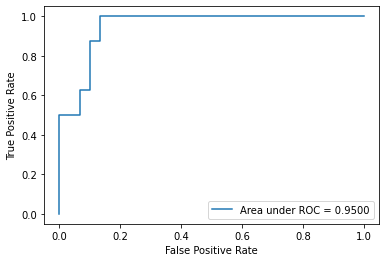

In [33]:
# Test1: Load the trained model 1 and test it on the testing data
test1 = test_model(trained_model1 , criterion, optimizer, plot_roc_curve = True)

In [30]:
#Train 2: call the second training model 2 with 500 epochs
trained_model2 = train_model(model, criterion, optimizer, num_epochs=500)

Epoch 0 running
[Train #0] Loss: 0.1900 Acc: 96.0265% Time: 2.2924s
Epoch 1 running
[Train #1] Loss: 0.1733 Acc: 96.0265% Time: 4.6080s
Epoch 2 running
[Train #2] Loss: 0.2057 Acc: 92.7152% Time: 6.9377s
Epoch 3 running
[Train #3] Loss: 0.1946 Acc: 94.7020% Time: 9.2113s
Epoch 4 running
[Train #4] Loss: 0.2036 Acc: 93.3775% Time: 11.4899s
Epoch 5 running
[Train #5] Loss: 0.1904 Acc: 96.0265% Time: 13.7812s
Epoch 6 running
[Train #6] Loss: 0.2065 Acc: 94.7020% Time: 16.0402s
Epoch 7 running
[Train #7] Loss: 0.2026 Acc: 93.3775% Time: 18.3360s
Epoch 8 running
[Train #8] Loss: 0.2002 Acc: 94.7020% Time: 20.6195s
Epoch 9 running
[Train #9] Loss: 0.1935 Acc: 94.0397% Time: 22.9008s
Epoch 10 running
[Train #10] Loss: 0.1840 Acc: 96.6887% Time: 25.1991s
Epoch 11 running
[Train #11] Loss: 0.1870 Acc: 95.3642% Time: 27.4885s
Epoch 12 running
[Train #12] Loss: 0.1791 Acc: 94.7020% Time: 29.7764s
Epoch 13 running
[Train #13] Loss: 0.1992 Acc: 95.3642% Time: 32.0623s
Epoch 14 running
[Train #14] L

Batch: 0
len of the test batch 32
Pred_list tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 0
target_list tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')  Batch: 0
Batch: 1
len of the test batch 6
Pred_list tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 1
target_list tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch: 1
[Test] Loss: 0.2611 Acc: 89.4737% Time: 0.3759s
######### Test Performance ###########
Accuracy 	 0.895
Sensitivity 	 0.625
Specificity 	 0.967
Area Under ROC 	 0.942


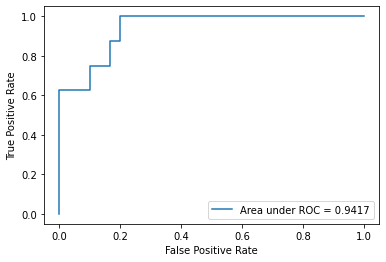

In [34]:
# Test 2: Load the trained model 2 and test it on the testing data
test2 = test_model(trained_model2, criterion, optimizer, plot_roc_curve = True)

**Train and Test with freezing (use the pretrained model as a fixed feature extractor)**

In [35]:
# freeze the pre-trained layers to not backprop through them during training
freezed_model = model
for param in freezed_model.parameters():
    param.requires_grad = False

num_ftrs = freezed_model.fc.in_features
freezed_model.fc = nn.Linear(num_ftrs, len(target_classes))

freezed_model = freezed_model.to(device)
criterion = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization algorithm
optimizer = optim.Adam(freezed_model.fc.parameters(), lr=0.0001)

In [36]:
# Train 3: call the training model 3 function with 200 epochs
trained_model3 = train_model(freezed_model, criterion, optimizer, num_epochs=200)

Epoch 0 running
[Train #0] Loss: 0.6654 Acc: 66.2252% Time: 2.2101s
Epoch 1 running
[Train #1] Loss: 0.6176 Acc: 80.1324% Time: 3.5111s
Epoch 2 running
[Train #2] Loss: 0.5830 Acc: 79.4702% Time: 4.7924s
Epoch 3 running
[Train #3] Loss: 0.5631 Acc: 79.4702% Time: 6.0705s
Epoch 4 running
[Train #4] Loss: 0.5305 Acc: 79.4702% Time: 7.3322s
Epoch 5 running
[Train #5] Loss: 0.5241 Acc: 79.4702% Time: 8.5995s
Epoch 6 running
[Train #6] Loss: 0.5056 Acc: 79.4702% Time: 9.8605s
Epoch 7 running
[Train #7] Loss: 0.4971 Acc: 79.4702% Time: 11.1033s
Epoch 8 running
[Train #8] Loss: 0.5049 Acc: 79.4702% Time: 12.3758s
Epoch 9 running
[Train #9] Loss: 0.5060 Acc: 79.4702% Time: 13.6169s
Epoch 10 running
[Train #10] Loss: 0.4893 Acc: 79.4702% Time: 14.8884s
Epoch 11 running
[Train #11] Loss: 0.4961 Acc: 79.4702% Time: 16.1619s
Epoch 12 running
[Train #12] Loss: 0.4894 Acc: 79.4702% Time: 17.4248s
Epoch 13 running
[Train #13] Loss: 0.4776 Acc: 79.4702% Time: 18.6739s
Epoch 14 running
[Train #14] Loss

Batch: 0
len of the test batch 32
Pred_list tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 0
target_list tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch: 0
Batch: 1
len of the test batch 6
Pred_list tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')  Batch= 1
target_list tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')  Batch: 1
[Test] Loss: 0.3708 Acc: 84.2105% Time: 0.3772s
######### Test Performance ###########
Accuracy 	 0.842
Sensitivity 	 0.375
Specificity 	 0.967
Area Under ROC 	 0.863


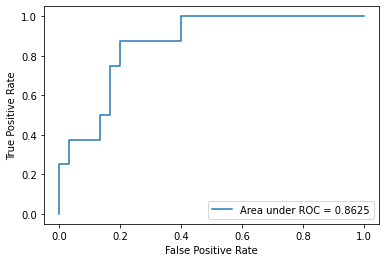

In [37]:
# Test 3: Load the trained model and test it on the testing data
test3 = test_model(trained_model3 , criterion, optimizer, plot_roc_curve = True)

In [38]:
# Train 4 : call the training model 4 function with 200 epochs
trained_model4 = train_model(freezed_model, criterion, optimizer, num_epochs=500)

Epoch 0 running
[Train #0] Loss: 0.1887 Acc: 94.0397% Time: 2.1298s
Epoch 1 running
[Train #1] Loss: 0.1903 Acc: 93.3775% Time: 4.1801s
Epoch 2 running
[Train #2] Loss: 0.1928 Acc: 94.0397% Time: 6.1670s
Epoch 3 running
[Train #3] Loss: 0.2104 Acc: 93.3775% Time: 7.4655s
Epoch 4 running
[Train #4] Loss: 0.2026 Acc: 93.3775% Time: 8.7548s
Epoch 5 running
[Train #5] Loss: 0.1982 Acc: 94.0397% Time: 10.0137s
Epoch 6 running
[Train #6] Loss: 0.1993 Acc: 94.7020% Time: 11.2718s
Epoch 7 running
[Train #7] Loss: 0.1915 Acc: 96.0265% Time: 12.5359s
Epoch 8 running
[Train #8] Loss: 0.1929 Acc: 96.6887% Time: 13.8147s
Epoch 9 running
[Train #9] Loss: 0.1929 Acc: 94.7020% Time: 15.0898s
Epoch 10 running
[Train #10] Loss: 0.2034 Acc: 96.0265% Time: 16.3774s
Epoch 11 running
[Train #11] Loss: 0.1845 Acc: 94.0397% Time: 17.6477s
Epoch 12 running
[Train #12] Loss: 0.2062 Acc: 94.7020% Time: 18.9295s
Epoch 13 running
[Train #13] Loss: 0.1834 Acc: 96.0265% Time: 20.1895s
Epoch 14 running
[Train #14] Lo

Batch: 0
len of the test batch 32
Pred_list tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 0
target_list tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch: 0
Batch: 1
len of the test batch 6
Pred_list tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch= 1
target_list tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')  Batch: 1
[Test] Loss: 0.2280 Acc: 89.4737% Time: 0.3737s
######### Test Performance ###########
Accuracy 	 0.895
Sensitivity 	 0.625
Specificity 	 0.967
Area Under ROC 	 0.967


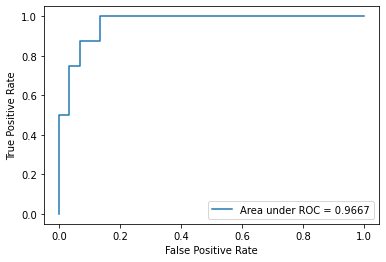

In [39]:
# Test 4: Load the trained model and test it on the testing data
test4 = test_model(trained_model4 , criterion, optimizer, plot_roc_curve = True)